# Using the Hazard Modeller's Toolkit - Earthquake Catalogue Examples 

This notebook contains: 

1. Read a seismic catalogue and pre-defined seismic sources. 

2. Explore basic methods for qualitative analysis of the catalogue. 

3. Declustering: Aftershocks and foreshocks identification and removal. 

4. Completeness

5. Estimation of the Gutenberg-Richter parameters. 

6. Exploration of some methods to estimate the maximum magnitude (statistically from the catalogue)


### Importing the libraries and Dependencies

To use the toolkit features we need to import at the start of the session those tools that we are planning to use.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline  

# Python dependences
import os
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
# from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                                get_completeness_adjusted_table,
                                                               _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hmtk.seismicity.declusterer.dec_afteran import Afteran 
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from openquake.hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                                         GruenthalWindow, 
                                                                         UhrhammerWindow)

# Completeness tools
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Max M Estimation methods
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment 

# Seismicity tools: Smoothed seismicity
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity 
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian 

print("Everything Imported OK!")

Everything Imported OK!


### Importing the Catalogue (+ Useful Methods!)

Seismic catalogue format

The hmtk is able to read a catalogue in .csv format (Windows comma separated values). 
There are a minimum number of fields that are required to import and use the catalogue 
information into hmtk. 
The fields require: 

        eventID* Agency year* month* day* hour* minute* second* longitude* latitude* depth* magnitude*

The fields marked with a star are mandatory.



In [3]:
#Importing catalogue
catalogue_filename = 'input_data/Overall_Seismicity_Formatted 2021.03.23.csv'
parser = CsvCatalogueParser(catalogue_filename) # From .csv to hmtk

# Read and process the catalogue content in a variable called "catalogue"
catalogue = parser.read_file(start_year=1900, end_year=2021)

# How many events in the catalogue?
print("The catalogue contains %g events" % catalogue.get_number_events())

# What is the geographical extent of the catalogue?
bbox = catalogue.get_bounding_box()
print("Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox)

The catalogue contains 11319 events
Catalogue ranges from 116.5453 E to 128.1380 E Longitude and 4.7910 N to 20.2820 N Latitude



It is generally a good idea for the catalogue to be input in chronological order.

If the catalogue is not in chronological order then the following re-sorts the catalogue in-place to ensure it is in order



In [4]:
catalogue.sort_catalogue_chronologically()

### Visualising the catalogue

#### Magnitude - Time Density

To see how the distribution of magnitudes changes with time we can simply plot magnitude against time:

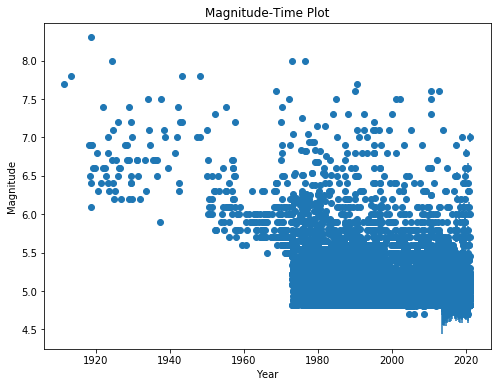

In [5]:
plot_magnitude_time_scatter(catalogue, plot_error=True)

Or, more informatively, plot the density of events with time

In [ ]:
magnitude_bin_width = 0.1  # In magnitude units
time_bin_width = 1.0 # In years
plot_magnitude_time_density(catalogue, magnitude_bin_width, time_bin_width)

### View the Depth Distribution

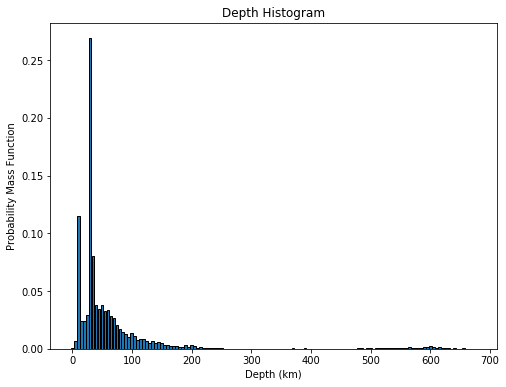

In [6]:
# Shows depth histogram every 5 km  
plot_depth_histogram(catalogue, 5., normalisation=True)

### Mapping the Catalogue

We can map the catalogue using the HMTK's mapping functions. A 'basemap' can support multiple layers:

In [7]:
# Map configuration
llon, ulon, llat, ulat = catalogue.get_bounding_box()
map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
              'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'i'}
# Creating a basemap - input a cconfiguration and (if desired) a title
# basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue')


# Adding the catalogue to the basemap
# In this case we will 'close' the figure after rendering, we do this by setting 'overlay=False'
# This is also the default option
# If we wanted to add another layer on top, we would set the overlay to True
# basemap1.add_catalogue(catalogue, overlay=False)

### Declustering

The HMTK supports several methods for declustering the earthquake catalogue:

1. Gardner & Knopoff (1974)

2. AFTERAN (Musson, 1999)

Others will (eventually) be added in the future

We illustrate the use of the Gardner & Knopoff Algorithm

#### Configuring the algorithm

In [8]:
# Create an `instance' of the tool
declust_method = GardnerKnopoffType1()

# Create a configuration file
declust_config = {"time_distance_window": GardnerKnopoffWindow(), "fs_time_prop": 1.0}

### Running the algorithm

All declustering algorithms produce two outputs:

* cluster_index = Vector indicating the number of the cluster to which the earthquake belongs (including mainshock)
* cluster_flag = Vector indicating if the event is a foreshock (-1), mainshock (0) or aftershock (1)

In [9]:
cluster_index, cluster_flag = declust_method.decluster(catalogue, declust_config)

data = np.column_stack([catalogue.get_decimal_time(),
                        catalogue.data['magnitude'],
                        catalogue.data['longitude'],
                        catalogue.data['latitude'], cluster_index, cluster_flag])
print('      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)')
for row in data:
    print('%14.8f  %6.2f  %8.3f  %8.3f  %6.0f  %6.0f' %(row[0], row[1], row[2], row[3], row[4], row[5]))

      Time    Magnitude    Long.    Lat.   Cluster No. Index (-1 = foreshock, 0 = mainshock, 1 = afterschock)
 1911.52649854    7.70   127.103     8.546       0       0
 1913.19825926    7.80   126.121     5.354       0       0
 1918.10197933    6.90   126.059     6.993      43      -1
 1918.49659167    6.50   126.468     8.957       0       0
 1918.62058286    8.30   124.377     5.967       1       0
 1918.62094051    6.40   124.261     5.213       1       1
 1918.62117615    6.90   125.750     5.226       0       0
 1918.62230914    6.10   124.660     5.289       1       1
 1919.00017849    6.90   126.530     6.819      43       0
 1919.31785008    6.60   120.410    12.353       0       0
 1919.73649109    6.60   124.098     6.850       0       0
 1920.34764129    6.80   126.808     6.831      43       1
 1920.58777699    6.30   127.902     5.841       0       0
 1921.38455518    6.40   125.524    12.669       0       0
 1921.85114133    6.60   126.849     7.145      14      -1
 1921

 1975.94614316    5.44   125.784    11.968      19       1
 1975.94680521    5.08   125.777    11.910      19       1
 1975.95306158    5.91   122.587     9.776     202       0
 1975.95322425    5.34   125.785    13.027      19       1
 1975.96235282    5.25   121.341    19.099     200       1
 1975.96483221    5.34   125.837     9.953     122       1
 1975.97288970    5.34   126.688     7.925     630       0
 1975.97343464    5.55   124.198     6.242       3      -1
 1975.97746047    5.29   126.571    11.243     529       1
 1975.98261976    5.01   120.134    17.379     140      -1
 1975.99528670    5.22   125.732    12.068      19       1
 1975.99739157    4.88   121.906    16.158       0       0
 1976.00129980    4.88   126.232    12.212      19       1
 1976.00291709    5.01   126.283    12.095      19       1
 1976.00564260    5.44   123.383     7.270       0       0
 1976.05920857    5.34   120.035    18.930     631       0
 1976.06717450    5.25   124.876     7.322       0      

 1984.70252964    5.25   126.643     5.434      64       1
 1984.70694164    5.08   126.217    12.523       0       0
 1984.71365376    5.25   126.287     9.550     417       1
 1984.71926783    5.09   126.897     5.748      64       1
 1984.72558916    4.88   125.278    14.112       0       0
 1984.72647041    5.80   120.923    18.424     269       0
 1984.72892811    5.22   126.556     6.928     304       1
 1984.73516091    5.60   122.582    12.021     385       0
 1984.73520032    5.01   122.696    11.926     385       1
 1984.74383125    5.08   120.938    18.310     269       1
 1984.74448306    5.25   124.285     5.818       0       0
 1984.75462167    4.94   126.170    11.335       0       0
 1984.75986936    5.16   119.125    18.586       0       0
 1984.77071392    5.01   121.328    13.414     966       1
 1984.77641299    4.82   119.737    17.727       0       0
 1984.78110567    5.01   119.954    15.446       0       0
 1984.78688608    5.16   126.010    10.221     369      

 1990.53815251    5.44   125.518     9.218     239       1
 1990.53815825    5.01   120.413    15.108       0       0
 1990.53817429    5.34   120.945    16.445      85      -1
 1990.53819053    4.88   120.215    16.421     302       1
 1990.53825278    4.82   120.472    16.057       5       1
 1990.53826899    4.82   121.123    16.383       5       1
 1990.53827634    4.88   120.391    15.683       5       1
 1990.53829810    5.01   120.496    16.291      85      -1
 1990.53831771    4.94   120.473    16.203     302       1
 1990.53838882    4.88   121.191    16.345       5       1
 1990.53839158    5.01   120.983    16.076       5       1
 1990.53841724    5.16   120.797    16.208       5       1
 1990.53847545    5.55   121.224    15.746       5       1
 1990.53850385    5.08   120.375    16.226     302       1
 1990.53852972    5.94   120.457    16.285      85      -1
 1990.53854713    5.08   120.505    16.304      85      -1
 1990.53855337    4.82   120.858    15.532       5      

 1995.30163492    4.82   125.828    11.723      20       1
 1995.30164236    5.44   125.549    12.267      20       1
 1995.30165360    4.88   125.386    12.216      20       1
 1995.30165842    5.16   125.588    12.256      20       1
 1995.30167178    4.94   125.513    12.246      20       1
 1995.30167317    4.94   126.414     6.948    1127       1
 1995.30167395    4.88   125.578    12.219      20       1
 1995.30169431    4.88   125.501    12.042      20       1
 1995.30172284    5.25   125.668    12.122      20       1
 1995.30173306    4.88   125.461    12.157      20       1
 1995.30175373    4.88   126.699    12.104    1198       1
 1995.30181538    4.88   125.448    11.722      20       1
 1995.30182749    4.94   125.151    12.033      20       1
 1995.30186914    4.88   125.582    12.231      20       1
 1995.30197036    5.08   125.904    12.003      20       1
 1995.30197303    6.80   125.920    12.047      20       1
 1995.30198796    5.25   125.877    12.086      20      

 1998.32321319    5.01   125.999    12.987    1091       0
 1998.33377877    5.15   125.840     5.921       0       0
 1998.34008989    4.94   121.977    19.615       0       0
 1998.34268104    5.80   120.938    18.716     160       1
 1998.34679195    5.10   123.435    12.239       0       0
 1998.34737762    5.00   121.029    19.198     160       1
 1998.35094414    5.20   121.000    20.087     563      -1
 1998.35130840    5.08   121.014    20.083     563      -1
 1998.37100799    4.88   121.067    19.156     160       1
 1998.37309717    4.88   127.265     9.351       0       0
 1998.37668615    4.88   125.311     9.243    1033       1
 1998.39106696    6.00   123.726     8.138       0       0
 1998.39606445    4.94   126.409     9.722      70       1
 1998.39669889    5.09   126.620     9.679      70       1
 1998.40244914    4.94   126.902     7.726     133       1
 1998.40246665    5.09   127.075     7.651      46       1
 1998.40625603    4.88   124.521    12.204       0      

 2005.21377556    5.10   126.535     7.607     290       1
 2005.21603634    4.88   125.451    11.950      84       1
 2005.21671257    4.94   125.446     9.729     883      -1
 2005.22814190    4.82   121.221    15.824       0       0
 2005.24278016    5.01   126.825     7.835    1098       0
 2005.24325600    4.94   125.338    12.202      84       1
 2005.24457688    5.22   126.470     9.290     481       1
 2005.24465314    4.94   126.559     9.286     481       1
 2005.24525413    4.90   124.376     9.607       0       0
 2005.24986011    4.88   126.005    12.435       0       0
 2005.25224799    5.60   120.801    13.559      86       1
 2005.26645704    5.30   119.287    15.480     483       1
 2005.27353199    4.82   125.713     9.288     951       1
 2005.28406635    5.10   120.271    13.716      86       1
 2005.29477236    5.01   121.361    19.060    1099       0
 2005.29595075    5.00   120.710    13.918      86       1
 2005.29723113    5.15   122.477    19.703       0      

 2009.30082321    5.20   120.238    15.387       0       0
 2009.30144133    4.88   121.622    18.770     898       1
 2009.30351525    5.10   126.292    12.274     922       0
 2009.31083676    5.00   121.357    18.945     492       1
 2009.34444345    4.88   125.253    12.721    1180       0
 2009.37320790    4.94   127.577     4.861     119       1
 2009.38423496    5.70   126.899     7.894     354       0
 2009.38442823    5.20   126.904     7.815     354       1
 2009.38525382    5.00   126.995     7.824     354       1
 2009.38537904    4.90   126.895     7.781     354       1
 2009.39190730    5.40   119.798    14.846     590       0
 2009.40562221    4.88   121.989     9.165      89      -1
 2009.40774601    5.70   125.776     5.927     118       1
 2009.41053097    5.01   126.464     6.776     494      -1
 2009.43232034    4.88   125.889    11.180       0       0
 2009.44465405    5.03   124.344    12.954     193       1
 2009.44999757    6.10   126.438     5.361     171      

 2014.00774876    5.22   126.393     8.690     593      -1
 2014.01283388    5.09   122.356     8.320       0       0
 2014.01289643    5.15   120.504    13.444     547      -1
 2014.02627954    4.82   121.125    18.974     972      -1
 2014.03040519    5.01   126.338     8.935     150       1
 2014.03163592    5.37   125.590     5.788     152       1
 2014.03780364    4.88   126.245     7.015     389       1
 2014.04499993    4.88   122.801    12.832    1190       0
 2014.04964875    5.03   126.364     8.643     593      -1
 2014.05399825    4.82   126.864     6.118     390      -1
 2014.05442061    4.88   122.519     9.763       0       0
 2014.05600314    4.94   120.284    13.715     547      -1
 2014.05776205    4.94   121.117    19.137     972      -1
 2014.06254755    5.16   119.856    18.069     819       0
 2014.06544612    4.82   125.819    11.917    1143       1
 2014.06777778    5.03   121.047    18.480       0       0
 2014.06880092    5.08   124.617    11.211     973      

 2018.89644053    5.03   126.154     6.095     107      -1
 2018.89969856    4.94   120.692    17.890    1144       0
 2018.90036245    4.82   126.288    10.377     184      -1
 2018.90098173    4.88   119.954    14.789     555       1
 2018.90919131    5.03   126.823     5.058     655       1
 2018.92752982    4.88   126.297     9.416     283      -1
 2018.93039141    5.30   125.670     6.659      54      -1
 2018.93757731    4.82   123.136     9.459    1172      -1
 2018.94180822    4.82   122.643    13.301       0       0
 2018.94195944    4.82   126.488     9.990     224      -1
 2018.94561969    5.15   120.783    13.812     130       1
 2018.94599908    4.94   119.751    13.469       0       0
 2018.94775307    5.09   125.313     4.981      44       1
 2018.94811051    4.94   127.028     5.582      36      -1
 2018.95624300    4.82   120.631    13.571     130       1
 2018.96642943    4.88   121.099    18.790     463      -1
 2018.96696730    5.09   126.292     6.640     332      

### Purging non-Poissonian Events from the Catalogue

Having run the declustering algorithm you may want to remove all of the 'non-Poissonian' events (i.e. foreshocks and aftershocks) from the catalogue

In [10]:
# Copying the catalogue and saving it under a new name "catalogue_dec"(declustered catalogue) 
catalogue_dec = deepcopy(catalogue)

# Logical indexing: Chossing the outputs for the main events: Cluster_flag = 0 
mainshock_flag = cluster_flag == 0 

# Filtering the foreshocks and aftershocks in the copy of the catalogue 
catalogue_dec.purge_catalogue(mainshock_flag)


# Printing the number of events considered main shocks
print('Declustering: ok')
print("Number of events in original catalogue: %g" % catalogue.get_number_events())
print('Number of mainshocks: %g' % catalogue_dec.get_number_events())

Declustering: ok
Number of events in original catalogue: 11319
Number of mainshocks: 2976


In [ ]:
# basemap1 = HMTKBaseMap(map_config, 'Declustered Earthquake Catalogue')
# basemap1.add_catalogue(catalogue_dec, overlay=False)

### Saving the catalogue

In [ ]:
# Selecting path and name for the output file 
output_cat_dec = 'output_data/Overall_Seismicity_Dec 2021.03.23.csv'

if os.path.exists(output_cat_dec):
    os.remove(output_cat_dec)

# Call the method and save the output file under the name "cat_csv"
cat_csv = CsvCatalogueWriter(output_cat_dec) 

# Write the purged catalogue
cat_csv.write_file(catalogue_dec)
print("Catalogue successfully written to %s" % output_cat_dec)

### Analysis of Completeness

In [ ]:
# Set up the configuration parameters
comp_config = {'magnitude_bin': 0.1, 'time_bin': 5.0, 'increment_lock': True}

# Calling the method
completeness_algorithm = Stepp1971()

# Use the catalogue and completeness configuration
completeness_table = completeness_algorithm.completeness(catalogue_dec, comp_config)
print('Completeness: ok')

# Print the completeness table
print('\n')
print('Completeness table using Stepp method (1971)')
print(completeness_table)
print('\n')

# Setting configuration for the completeness plot
completeness_parameters = completeness_algorithm
output_file = "output_data/Project_Completeness_Overall_Plot.png"
if os.path.exists(output_file):
    os.remove(output_file)
#plot_stepp_1972.create_stepp_plot(completeness_parameters, output_file)
plot_stepp_1972.create_stepp_plot(completeness_parameters, figure_size=(8, 6), 
                                  filename=output_file, filetype='png', dpi=300, ax=None)

### Manual setup of the completeness table

The hmtk allows to use a completeness table proposed by the modeller. 

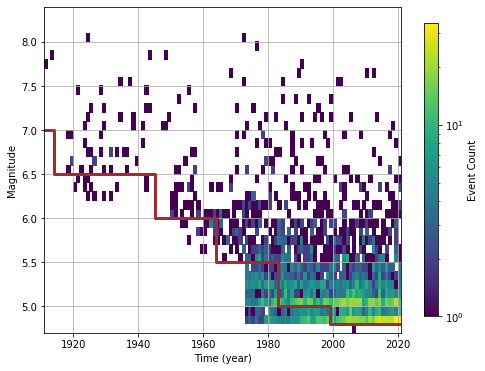

In [12]:
# Table format


completeness_table_a = np.array([[1999., 4.8],
                                 [1983., 5.0],
                                 [1964., 5.5],
                                 [1945., 6.0],
                                 [1914., 6.5],
                                 [1910., 7.0],
                                 [1908., 7.5],
                                 [1908., 8.0]])

plot_magnitude_time_density(catalogue_dec, 0.1, 1.0,
                            completeness=completeness_table_a, figure_size=(8, 6), 
                                  filename="global_Stepp_plot", filetype='png', dpi=300, ax=None)

# Estimating Recurrence

Several methods are available for estimating recurrence taking into account time-dependent completeness

1. 'Weighted' Maximum Likelihood
2. Kijko & Smit (2012)
3. Weichert (1980)
4. Penalized Maximum Likelihood (Johnston et al., 1994)

In [13]:
recurrence_estimator = Weichert()

recurrence_config = {"magnitude_interval": 0.1}

bval, sigma_b, aval, sigma_a = recurrence_estimator.calculate(catalogue_dec,
                                                              recurrence_config,
                                                              completeness_table_a)

print("a = %.3f (+/- %.3f),  b = %.3f (+/-%.3f)" % (aval, sigma_a, bval, sigma_b))

a = 7.206 (+/- 0.009),  b = 1.122 (+/-0.018)


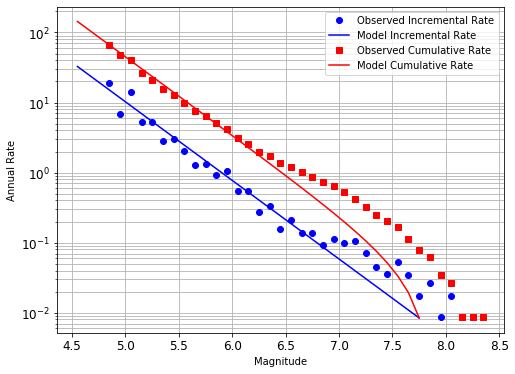

In [15]:
mfd0 = TruncatedGRMFD(4.5, 7.8, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1, figure_size=(8, 6), 
                                  filename="plot overall recurrence", filetype='png', dpi=300, ax=None)

### Inferring Maximum Magnitude

The toolkit contains several tools for making statistical inferences on the maximum magnitude using the earthquake catalogue.

Three of these are based on the methods proposed by Kijko (2004):

1. KijkoSellevolFixedb - Maximum likelihood estimator of $M_{MAX}$ assuming no uncertainty in the b-value

2. KijkoSellevolBayes - Maximum likelihood estimator of $M_{MAX}$ assuming an uncertain b-value

3. KijkoNonParametricGaussian -Maximum likelihood estimator of $M_{MAX}$ assuming no specific magnitude frequency distribution

More details are given in the HMTK manual.

An additional method - based on cumulative moment release (adaptation of Makropolous & Burton (1983)) is also included



#### Example: Kijko-Sellevol-Bayes Approach

In [ ]:
# Create the configuration
mmax_config = {
    "input_mmin": 5.0,
    "input_mmax": None,   # It will take the maximum observed in the catalogue
    "input_mmax_uncertainty": None,  # It will take the uncertainty of the maximum observed in the catalogue
    "b-value": bval,
    "sigma-b": sigma_b
}

# Instantiate the tool
mmax_estimator = KijkoSellevolBayes()
# Execute!
mmax, sigma_mmax = mmax_estimator.get_mmax(catalogue_dec, mmax_config)
print("Maximum Magnitude (Estimated - KSB): %.3f +/- %.3f" % (mmax, sigma_mmax))

#### Example: Kijko-Sellevol Fixed-b Approach

In [ ]:
mmax_estimator2 = KijkoSellevolFixedb()
mmax2, sigma_mmax2 = mmax_estimator2.get_mmax(catalogue_dec, mmax_config)
print("Maximum Magnitude (Estimated - K-S-fixed-b): %.3f +/- %.3f" % (mmax2, sigma_mmax2))

In [ ]:
mfd0 = TruncatedGRMFD(4.5, mmax, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

#### Example: Cumulative Moment Approach 

In [ ]:
mmax_cm_config = {"number_bootstraps": 100}

mmax_estimator3 = CumulativeMoment()
mmax3, sigma_mmax3 = mmax_estimator3.get_mmax(catalogue_dec, mmax_cm_config)

print("Maximum Magnitude (Cumulative Moment): %.3f +/- %.3f" % (mmax3, sigma_mmax3))

mfd0 = TruncatedGRMFD(4.5, mmax3, 0.1, aval, bval)
plot_recurrence_model(mfd0, catalogue_dec, completeness_table_a, 0.1)

In [ ]:
plot_cumulative_moment(catalogue_dec.data["year"], catalogue_dec.data["magnitude"])